### Basic training example
This notebook is an example of how to receive spectroscopic data in the form of a coincidence matrix and singles spectrum, convert into training data, and then train a word2vec model

In [3]:
# Setup
import os
import io
import re
import string
import tqdm
import math
import random

import numpy as np

# Disable GPU acceleration by default
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib
import matplotlib.pyplot as plt

# Load the TensorBoard notebook extension
%load_ext tensorboard

SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
# Describe available GPU acceleration, if any
print(tf.config.list_physical_devices('GPU'))

[]


#### Construct training sample

In [5]:
class Translator:
    def __init__(self, rmin, rmax, nbins, verbose=False):
        self.rmin = rmin
        self.rmax = rmax
        self.nbins = nbins
        self.verbose = verbose
        self.binwidth = float(self.rmax - self.rmin)/self.nbins
        
    def bin(self, energy):
        b = int((energy - self.rmin)/self.binwidth)
        if b > self.nbins - 1:
            if self.verbose:
                print("Energy out of range: ", energy)
            b = self.nbins - 1
        elif b < 0:
            if self.verbose:
                print("Energy out of range: ", energy)
            b = 0
            
        return b

In [5]:
# Read in data from event file
inFile = open('../events.txt','r')
content = inFile.readlines()

# allEvents is a dictionary with format <timestep> : <list of recorded energies>
allEvents = {}
for line in content:
    line = line.strip('\n') # Removes the line break
    data = line.split(',')  # Separates data by location of comma
    ts = int(data[0])
    energies = [float(d) for d in data[1:]]
    allEvents[ts] = energies

In [6]:
# Create 1D histogram (singles)
eMin = 0
eMax = 7000
numBins = int((eMax - eMin)/10)
t = Translator(eMin, eMax, numBins, verbose=True)

hSingles = np.zeros(numBins)
for ts in allEvents:
    for energy in allEvents[ts]:
        hSingles[t.bin(energy)] += 1


Energy out of range:  8357.443359375
Energy out of range:  7963.53564453125
Energy out of range:  8051.01220703125
Energy out of range:  9663.6376953125


In [7]:
# Create 2D matrix to hold bins
# TODO make sparse
hCoincidences = np.zeros((numBins, numBins))

# Loop over all events; fill histogram
for ts in allEvents:
    eList = allEvents[ts]
    nC = len(eList)
    for i in range(nC):
        for j in range(i+1, nC):
            ei = eList[i]
            ej = eList[j]
            hCoincidences[t.bin(ei), t.bin(ej)] += 1
            hCoincidences[t.bin(ej), t.bin(ei)] += 1

In [8]:
# Project 2D histogram into a single dimension
hProjection = np.sum(hCoincidences, axis=0)

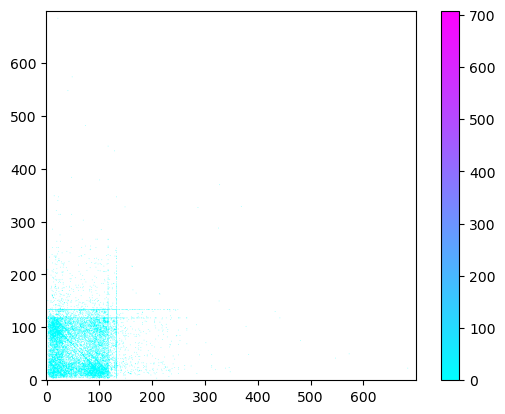

In [9]:
# Plot the 2D histogram as a sanity check.
# 
# What we actually plot is a subsampling of the histogram data, because
# in many cases there will be more bins than available pixels, and the
# resulting images are hard to interpret. Increasing the 'subsample' value
# will collapse multiple bins into increasingly large new bins, which are
# then plotted

# Subsampling ratio, change as needed
# subsample = 20
subsample = 1

# n.b. this does not do anything graceful when 'subsample'
#      does not divide evenly into 'nb', but that's probably fine
#      because there is very little data in the highest bin.
nbNew = math.ceil(numBins/subsample)
hCoincSub = np.zeros((nbNew, nbNew))

# fyi: this loop can take 10-20 seconds
for i in range(numBins):
    for j in range(numBins):
        isub = int(i/subsample)
        jsub = int(j/subsample)
        hCoincSub[isub, jsub] += hCoincidences[i, j]

# Create alpha (transparency) channel
# This plots a transparent pixel wherever the bin count is 0
# As a result, it's much easier to see where the nonzero data is
alpha = (hCoincSub != 0).astype(float)

# Plot 2D histogram
plt.imshow(hCoincSub, origin='lower', alpha=alpha, cmap='cool')
plt.colorbar()
plt.show()

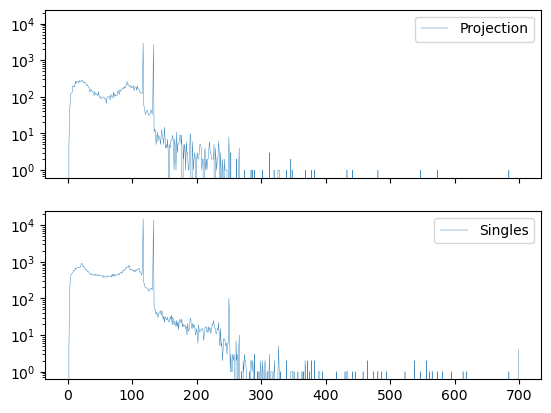

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True)
ax1.plot(hProjection, linewidth=0.3, label="Projection")
ax1.semilogy()
ax1.legend()

ax2.plot(hSingles, linewidth=0.3, label="Singles")
ax2.semilogy()
ax2.legend()
plt.show()

In [11]:
# Create a frequency dictionary {binNumber:totalCounts}
binToFreq = {}
for i in range(numBins):
    binToFreq.update({i:hProjection[i]})   

order = 0
binToOrder = np.zeros((numBins,), dtype="int64")
orderToBin = np.zeros((numBins,), dtype="int64")
for b in sorted(binToFreq, key=binToFreq.get, reverse=True):
    binToOrder[b] = order
    orderToBin[order] = b
    order += 1

print(binToOrder[:20])
print(orderToBin[:20])

[267 268 164 129 114  77  74  70  29  33  31  37   7  19   8  10  12  14
   3  13]
[117 133  22  18  23  21  20  12  14  92  15  25  16  19  17  24  27  26
  28  13]


In [12]:
# Randomly sample indices from the sorted list using the log-uniform distribution
def sample_random_log_uniform_bin(sorted_list):
    
    # Define the minimum and maximum exponents for the log-uniform distribution
    min_exp = 0
    max_exp = math.log10(sorted_list[-1])
    
    # Generate a random exponent within the defined range
    random_exp = random.uniform(min_exp, max_exp)

    # Calculate the corresponding index in the sorted list
    index = int(10 ** random_exp) - 1

    # Sample the value at the generated index
    sampled_value = sorted_list[index]

    #return sampled_value
    return index

In [30]:
# Generate positive and negative skip-gram examples
positive_skip_grams = []
negative_skip_grams = []
num_neg_examples=20

"""
'binToOrder' is an array that gives the frequency order of each bin.
So, binToOrder[i] gives the order of bin i in terms of frequency.

'orderToBin' is the opposite of binToOrder. That is,
if   j = binToOrder[i]
then i = orderToBin[j]

In other words, orderToBin[i] gives the bin index for the ith-most 
frequent bin.
"""

for e in allEvents:
    # Coincidence event; not a single
    if len(allEvents[e])>1: 
        # Loop through all pairs of energies in this event
        # energy1 is treated as 'target' gamma
        # energy2 is treated as 'context' gamma
        for energy1 in allEvents[e]:
            for energy2 in allEvents[e]:
                if energy1 == energy2:
                    continue
                else:
                    bin1 = t.bin(energy1)
                    bin2 = t.bin(energy2)
                    order1 = binToOrder[bin1]
                    order2 = binToOrder[bin2]
                    skip_gram = (order1, order2)
                    positive_skip_grams.append(skip_gram)
                    
                    # Now make negative skip-grams
                    for neg in range(num_neg_examples):
                        negOrder = sample_random_log_uniform_bin(orderToBin)
                        skip_gram = (order1, negOrder)
                        negative_skip_grams.append(skip_gram)

# print(positive_skip_grams)
# print(negative_skip_grams)

In [31]:
seed = 1
num_ns = num_neg_examples
vocab_size = numBins
context_word = 50

context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)

negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
  true_classes=context_class,
  num_true=1,
  num_sampled=num_ns,
  unique=True,
  range_max=vocab_size,
  seed=seed,
  name="negative_sampling")

print(context_class)
print(negative_sampling_candidates)

tf.Tensor([[50]], shape=(1, 1), dtype=int64)
tf.Tensor(
[393  13  87 100   1   5   3  20  52  11  47  21   6   0  85   7 457 225
 376  75], shape=(20,), dtype=int64)


In [32]:
def parse_skip_grams(pos, neg):
    targets, contexts, labels = [], [], []
    
    for i in range(len(pos)):
        sg = pos[i]
        target_word = sg[0]
        pos_context = sg[1]
        neg_context_words = []
        for j in range(num_neg_examples):
            neg_sg = neg[i*num_neg_examples + j]
            neg_target = neg_sg[0]
            neg_context = neg_sg[1]
            if (neg_target != target_word):
                print("Target words do not match:", target_word, neg_target)
                
            neg_context_words += [neg_context]
        
        context = tf.concat([tf.constant([pos_context], dtype="int64"), 
                                 tf.constant(neg_context_words, dtype="int64")], 0)
        label = tf.constant([1] + [0]*num_ns, dtype="int64")

        targets.append(target_word)
        contexts.append(context)
        labels.append(label)

    return targets, contexts, labels

In [33]:
targets, contexts, labels = parse_skip_grams(positive_skip_grams, negative_skip_grams)


In [34]:
targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print(f"targets length: {len(targets)}")
print(f"contexts length: {len(contexts)}")
print(f"labels length: {len(labels)}")

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

# print(targets[:15])
# print(*contexts[:15])
# print(labels[:15])

targets length: 25044
contexts length: 25044
labels length: 25044


targets.shape: (25044,)
contexts.shape: (25044, 21)
labels.shape: (25044, 21)


In [35]:
# Configure dataset for performance

# use tf.data.Dataset API for efficient batching of potentially large numbers of training examples.
# After this step, you would have a tf.data.Dataset object
# of (target_word, context_word), (label) elements to train your word2vec model!
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

# Apply `Dataset.cache` and `Dataset.prefetch` to improve performance:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 21), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 21), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 21), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 21), dtype=tf.int64, name=None))>


In [36]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num_ns+1)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [37]:
# Instatiate word2vec and compile with tf.keras.optimizers.Adam optimizer
embedding_dim = 80
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [49]:
# #define a callback to log training statistics for TensorBoard:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Train the model on the `dataset` for some number of epochs:
word2vec.fit(dataset, epochs=40, callbacks=[tensorboard_callback])

Epoch 1/40
24/24 [==============================] - 0s 5ms/step - loss: 2.1766 - accuracy: 0.3157
Epoch 2/40
24/24 [==============================] - 0s 4ms/step - loss: 2.1760 - accuracy: 0.3160
Epoch 3/40
24/24 [==============================] - 0s 4ms/step - loss: 2.1755 - accuracy: 0.3160
Epoch 4/40
24/24 [==============================] - 0s 4ms/step - loss: 2.1749 - accuracy: 0.3162
Epoch 5/40
24/24 [==============================] - 0s 4ms/step - loss: 2.1744 - accuracy: 0.3166
Epoch 6/40
24/24 [==============================] - 0s 4ms/step - loss: 2.1738 - accuracy: 0.3166
Epoch 7/40
24/24 [==============================] - 0s 4ms/step - loss: 2.1733 - accuracy: 0.3169
Epoch 8/40
24/24 [==============================] - 0s 4ms/step - loss: 2.1727 - accuracy: 0.3171
Epoch 9/40
24/24 [==============================] - 0s 4ms/step - loss: 2.1722 - accuracy: 0.3170
Epoch 10/40
24/24 [==============================] - 0s 4ms/step - loss: 2.1717 - accuracy: 0.3171
Epoch 11/40
24/24 [

In [22]:
#docs_infra: no_execute
%tensorboard --logdir logs --host localhost
# !kill 364

# %tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 7240), started 55 days, 23:10:35 ago. (Use '!kill 7240' to kill it.)

In [50]:
# Extract the weights and vocabulary objects to inspect
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = orderToBin

### Analysis
From here, one can inspect the embedding to observe any patterns of interest in the embedding space. The following code cells are just simple examples of how bins can be inspected in embedding space.

In [51]:
out_v = io.open('gamma-vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('gamma-metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(str(word) + "\n")
out_v.close()
out_m.close()

In [52]:
print("Most frequent bins:")
print(orderToBin[:20])

Most frequent bins:
[117 133  22  18  23  21  20  12  14  92  15  25  16  19  17  24  27  26
  28  13]


In [53]:
mybin = 117
j = binToOrder[mybin]
# j = 1174
dots = np.zeros((numBins,))
for i in range(numBins):
    dot = 0
    for k in range(embedding_dim):
        dot += weights[binToOrder[i]][k]*weights[j][k]
    dots[i] = dot
    


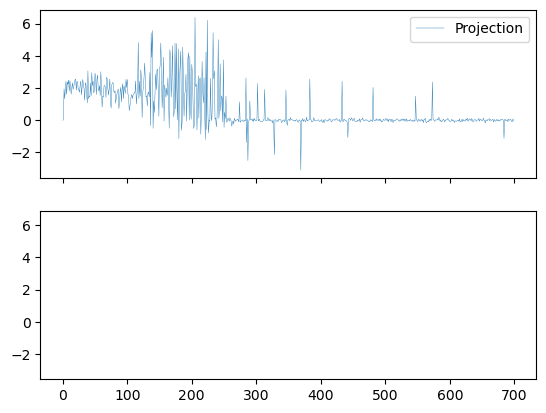

In [54]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True)
ax1.plot(dots, linewidth=0.3, label="Projection")
ax1.legend()

plt.show()

In [28]:
dot = 0
dist = 0
a = 117
b = 133
for k in range(embedding_dim):
    wa = weights[binToOrder[a]][k]
    wb = weights[binToOrder[b]][k]
    dot += wa*wb
    dist += (wa-wb)**2
    
print("dot prod:", dot)
print("distance:", dist)

dot prod: 1.5970670578535646
distance: 5.023211121533934


In [ ]:
# Subsampling ratio, change as needed
subsample = 20

# n.b. this does not do anything graceful when 'subsample'
#      does not divide evenly into 'nb', but that's probably fine
#      because there is very little data in the highest bin.
nb = dots.shape[0]
nbNew = math.ceil(nb/subsample)
dotsSub = np.zeros((nbNew, nbNew))

# fyi: this loop can take 10-20 seconds
for i in range(nb):
    for j in range(nb):
        isub = int(i/subsample)
        jsub = int(j/subsample)
        dotsSub[isub, jsub] += dots[i, j]

# Create alpha (transparency) channel
# This plots a transparent pixel wherever the bin count is 0
# As a result, it's much easier to see where the nonzero data is
alpha = (dotsSub != 0).astype(float)

# Plot 2D histogram
plt.imshow(dotsSub, origin='lower', alpha=alpha, cmap='cool')
plt.colorbar()
plt.show()